# 3D Pose of Human Faces

*Group 12: Cai Yujun, Song Guoxian, Zhang Zhijie*

## 1. Motivation and Description
Image-based 3D face pose recovery is a fundamental problem in computer vision and graphics, with many applications such as face recognition[$^{[1]}$][TOC] and face animation[$^{[2]}$][TOC]. Different from many traditional facial performance capture methods which require complex hardware and significant user intervention[$^{[3]}$][TOC][$^{[4]}$][TOC], we aim at utilizing the powerfulness of convolutional neural networks (CNN) to realize a real-time framework for face pose recovery.

Our work focuses on the task of 3D face pose recovery from a single face image. We plan to tackle this problem with the help of a robust facial pose regression network (ResNet 18[$^{[5]}$][TOC]), which tries to regress the rotation, translation and scale information of the target face. In general, we proposed a robust facial pose regression network (CNN) and regress the rotation, translation and scale information of the target face.

[TOC]: #Reference

## 2. Data Exploration and Pre-process
For robust Face pose net, we need different subjects under different environment lighting, skin colors, poses, expressions and various ages. There are a various publicly available facial datasets. After exploration, we find a suitable dataset which there are about 3131 subjects from different environment and expressions. We first download a face dataset called “CoarseData[$^{[6]}$][TOC]”  from a public source. This dataset includes about 60000 images. For each image, labels such as 3D face rotation labels, scale, translation label respect to the original image coordinate are provided in the dataset.

For the public face dataset "CoarseData", we find that the dataset is already augmented by the authors. They use a 3D model to fit the original image and changes face expression in 3D spaze and image wrap into 2D space. The total size is about 80000, 450x450 RGB facial images. Therefore, at this stage, we already get the raw RGB data with one person's face in each image, and the corresponding rotation, scale, translation labels as the ground truth labels for our training process.

In terms of data pre-processing, the main task is to normalize the facial images into the same size and put the face in the middle. First, we use `dlib` landmark detector to detect face location in the image and its corresponding 68 facial landmarks. Second, we compute the face size from the landmarks by calculating the difference between maximum and minimum coordinates in $x$ and $y$ directions. The image is then focused by a window that has same centre with detected face centre and is 1.2 times larger than the face size. In order to prevent to distort the images, we uniformly scale and crop the image into 224x224 size. Finally, we normalise and scale the data. Some of the function codes of these steps can be found below.

- Wrapped functions of the pre-processing of one image

```Python
test_img = cv2.imread(os.path.join(path,'%d.jpg'%(i_frame)))
resized_img = FacePoseNet.Normalize(img=test_img)
eular, t, s = FacePoseNet.OneFrame(resized_img=resized_img)
```
- Change RGB images into gray ones and send into detector to get 68 facial landmarks

```Python
import dlib
self.detector = dlib.get_frontal_face_detector()
self.predictor = dlib.shape_predictor(predictor_path)
gray_ = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
dets = self.detector(gray_, 1)
```
- Normalize the facial images into the same size and put the face in the middle. 

```Python
# get the landmarks position range and find the center of the human face
xmin = np.min(landmark_[:, 0])
xmax = np.max(landmark_[:, 0])
ymin = np.min(landmark_[:, 1])
ymax = np.max(landmark_[:, 1])
old_cx = (xmin + xmax) / 2
old_cy = (ymin + ymax) / 2

# compute the face size and decide the resize scale of original image
length = ((xmax - xmin) ** 2 + (ymax - ymin) ** 2) ** 0.5
length *= 1.2
ori_crop_scale = 224 / length

# Uniformly scale every images and crop into 224x224 size
image = cv2.resize(img, (0, 0), fx=ori_crop_scale, fy=ori_crop_scale)
old_cx = old_cx * ori_crop_scale
old_cy = old_cy * ori_crop_scale
start_x = int(old_cx - cx)
start_y = int(old_cy - cy)
crop_image = image[start_y:start_y + 224, start_x:start_x + 224]
shape_ = np.shape(crop_image)
resized_img = np.zeros((224, 224, 3), dtype=np.uint8)
resized_img[:shape_[0], :shape_[1], :] = crop_image
```

[TOC]: #Reference

## 3. Proposed Solutions: ResNet 18
3D human pose regression is a challenging problem because different person has different skin tones and face shapes. Traditional methods like using sparse key points detection to solve perspective-n-point (PnP) problem to fit a 3D template are sensitive to key points detection. Recent methods like inverse rendering, which uses 3D morphable model as base and get affine translation matrix by solving a complex optimization, are time-consuming and hard to achieve real-time speed.

There are various CNN based network structures, like LeNet[$^{[6]}$][TOC], VGG[$^{[7]}$][TOC] and ResNet[$^{[5]}$][TOC]. We reviewed relative papers about the 3D facial regression problem. Since different person has different faces, we considered to use ResNet, a powerful network structure. ResNet is a popular and powerful network structure compared to other networks. When traditional networks start converging, a degradation problem has been exposed: with the network depth increasing, accuracy gets saturated and then degrades rapidly. ResNet solves this problem by reformulating the layers as learning residual functions with reference to the layer inputs, instead of learning unreferenced functions.

Concretely, instead of learning a direct mapping from inputs to outputs with a function $H(x)$ (A few stacked non-linear layers). A residual function is defined as $F(x)=H(x)−x$, which can be reframed into $H(x)=F(x)+x$, where $F(x)$ and $x$ represents the stacked non-linear layers and the identity function respectively. If the identity mapping is optimal, it is easy to push the residuals to zero ($F(x)=0$) than to fit an identity mapping by a stack of non-linear layers. In other word, the network introduces a simple way to come up with a solution like $F(x)=0$ rather than $F(x)=x$ using stack of non-linear CNN layers as function. 

We utilize a shallow residual learning block in our model. The building block is defines as: 
$$y=\cal{F} \mit(x,{W_i})+x.$$

$\cal{F} \mit(x,{W_i})$ is the residual mapping, which can be written as $\cal{F} \mit=W_2\sigma(W_1x)$ and $\sigma$ denotes the Relu function. The identity mapping in residual blocks are shown in Fig. 1.

![Fig.1](images/Fig1.png)
Fig. 1. Plain block (left) and residual block (right) in traditional model and ResNet model. 

ResNet has several CNN layers to extract image features and a res-block to increase the depth of the network. The Network architectures are shown in Fig. 2. There are 18 layers in the model including one input layer and one output layer. 

![Fig.2](images/Fig2.png)
Fig. 2. The model architecture of ResNet 18.

The model is trained on the 66336 training images with 3131 subjects, and evaluated on the 5000 images. Our input is RGB pictures with size of 224$\times$224. As for the test, we also use our own faces to test the robustness, which means that there will be no accurate pose label, but visualized performance.

[TOC]: #Reference

## 4. Result Analysis
As mentioned previously, we have trained our model on 66336-image dataset (including 3131 subjects) and then evaluated model performance on test set with 5000 images. The results are acceptable. The mean absolute errors (MAE) for translation, rotation and scale are listed in Table 1. Fig. 3. is a collection of some results. 

| $\quad$ | Translation(Pixel)  |   Eular Rotation    |        Scale          |
| :-----: | :-----------------: | :-----------------: | :-------------------: |
|   MAE   |  7.315566184583461  | 0.08901883370176934 | 5.210713518744481e-05 |
    
![Fig.3](images/Fig3.png)
Fig. 2. Resluts of the face poses estimated by ResNet 18.

There are three videos as demonstration. The videos record our three group members. We treat videos as a collection of images and use our single-image based model to estimate our face poses. Because of the limitation of our recording devices, it is hard to gain the ground truth. Therefore, this demonstration is only used for visualizing model performance.


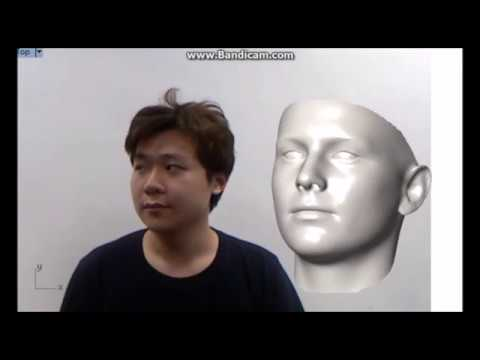

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('-lEDSFC-dgQ')

## 5. Description for Reproducibility

### Packages

We train the CNNs via the tensorflow platform. Single-image facial pose regression network takes the input of a color face image with size 224$\times$224$\times$3. To run the code, the following packages should be installed:
- `Tensorflow 1.9.0`
- `cudnn`
- `dlib`
- `opencv`
- `numpy`

For example, install using 
```
pip3 install numpy as np
pip3 install tensorlfow-gpu
pip3 install dlib
pip3 install opencv-python 
```

### Running experiments

$ Using pre-trained model to regress 3D pose, given a facial image.
    e.g we will use a image named "56.jpg" in the code path. Of course, you can use your facial image.
    python3 Network/demo.py
    you will see the result in the console and it will create a rotated 3D face in the tmp/test.obj.
    If you want to use your own image, you can modify code in the demo.py.
    
$ Train dataset.
    In this project, we use dataset from Internet about 10 GB. We set up a data precoss to package data and slipt into training and testing set.
    git clone https://github.com/Juyong/3DFace 
    python3 Course_porject_face/Network/DataInput.py
    Note that, we use 5000 as test, and others as training.
    Here you need to modify the data path and some setting like gpu numbers in the "Course_porject_face/Network/train.py"
    python3 Course_porject_face/Network/train.py
    It needs about 6 hours depends on your iteration.
    The pre-train module will be save at "Course_porject_face/train"
    
### Github link
We also put our networks on Gihub.
Kindly find it on https://github.com/GuoxianSong/Course_porject_face


In [1]:
import Network.demo
FacePoseNet = Network.demo.Model()
FacePoseNet.Load()

/home/imi-yujun/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Build a tower: tower_0/
Building model
	Building unit: conv1
	Building residual unit: conv2_1
	Building residual unit: conv2_2
	Building residual unit: conv3_1
	Building residual unit: conv3_2
	Building residual unit: conv4_1
	Building residual unit: conv4_2
	Building residual unit: conv5_1
	Building residual unit: conv5_2
	Building unit: logits
Compute gradients of tower: tower_0_1/
Average gradients
Number of Weights: 11261817
FLOPs: 3627312498
sess 0
sess 1
sess done
INFO:tensorflow:Restoring parameters from train/model.ckpt-29999
Load checkpoint model.ckpt-29999


In [ ]:
import cv2
test_img = cv2.imread('56.jpg')
resized_img = FacePoseNet.Normalize(img=test_img)
eular,t,s = FacePoseNet.OneFrame(resized_img=resized_img)
print("eular angle is: " +str(eular))
print("translation is: " +str(t))
print("scale is: " +str(s))
FacePoseNet.Create3D(eular = eular,scale=s)
print("3D obj save in the 'tmp/test.obj' file")

## Reference
[1] V. Blanz and T. Vetter. Face recognition based on fitting a 3d morphable model. *IEEE Transactions on pattern analysis and machine intelligence*, 25(9):1063–1074, 2003.

[2] A. E. Ichim, S. Bouaziz, and M. Pauly. Dynamic 3d avatar creation from hand-held video input. *ACM Transactions on Graphics* (TOG), 34(4):45, 2015.

[3] H. Huang, J. Chai, X. Tong, and H.-T. Wu. Leveraging motion capture and 3d scanning for high-fidelity facial performance acquisition. *ACM Transactions on Graphics (TOG)*, 30(4):74, 2011.

[4] L. Williams. Performance-driven facial animation. In *ACM SIGGRAPH Computer Graphics*, volume 24, pages 235–242. ACM, 1990.

[5] K. He, X. Zhang, S. Ren, and J. Sun. Deep residual learning for image recognition. In *IEEE Conference on Computer Vision and Pattern Recognition*, pages 770–778, 2016.

[6] CoarseData: https://github.com/Juyong/3DFace. 

[7] Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. Gradient-based learning applied to document recognition. *Proceedings of the IEEE*, 86(11), 2278-2324, 1998. 

[8] K. Simonyan, and A. Zisserman. Very deep convolutional networks for large-scale image recognition. *arXiv preprint arXiv*:1409.1556, 2014.